오늘은 주택 가격 예측 모델의 베이스라인을 잡을거에요.

주택 가격 데이터는 캐글에서 [다운로드](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques) 하시면 되구요.

In [348]:
data_name = 'house_price.csv'
target_name = 'SalePrice'

스크립트 실행 시에 경고를 제거할거에요.

경고를 읽는 것은 좋지만 출력이 어지럽답니다.

In [349]:
import warnings
warnings.filterwarnings('ignore')

이제 캐글 데이터를 불러오구요.

타겟 이름에 따라 데이터를 분할할거에요.
- 피처와 타겟 데이터

In [357]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 10)

data = pd.read_csv(data_name)

print(f'data shape = {data.shape}')
data.head(2)

data shape = (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,...,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,...,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,...,5,2007,WD,Normal,181500


회귀 분석에서 타겟 분포는 매우 중요해요.

정규성을 만족하는지 확인 필요할 것 같네요.

In [359]:
from scipy.stats import kstest

statistics, pvalue = kstest(
    data[target_name], 'norm',
    args=(
        data[target_name].mean(), 
        data[target_name].var() ** 0.5)
)
print(f'normal pvalue = {pvalue:.3f}')

normal pvalue = 0.000


매우 작은 값이 나왔는데요.

이는 정규 분포와 다르다는 것을 의미해요.

정규 분포를 따지는 두가지가 있는데 알고 계시나요?
- 왜도가 절대값 10 이하
- 첨도는 절대값 3 미만

먼저 첨도를 확인해보면 위로 뾰족한 형태로 망했네요.

In [360]:
from scipy.stats import kurtosis

kurtosis_ = kurtosis(data[target_name], fisher=False)
print(f'kurtosis = {kurtosis_: .3f}')

kurtosis =  9.510


디행이도 왜도의 경우는 정규성 조건을 만족해요.

In [361]:
from scipy.stats import skew

skewness = skew(data[target_name])
print(f'skewness = {skewness: .3f}')

skewness =  1.881


하지만 걱정하지 마세요.

데이터에 로그를 씌운다면 이를 해결할 수 있어요.

아래와 같이 정규 분포와 거의 유사한 모습을 볼 수 있어요.

In [362]:
data[target_name] = data[target_name].apply(
    lambda x: np.log1p(x)
)

kurtosis_ = kurtosis(data[target_name], fisher=False)

skewness = skew(data[target_name])

print(f'kurtosis = {kurtosis_: .3f} skewness = {skewness: .3f}')

kurtosis =  3.803 skewness =  0.121


다음으로 중요한 피처가 어떠한 것들이 있는지 쓱 파악할거에요.

그 방법으로 피처 선택 모델을 활용합니다.
- 선택할 피처 개수는 50개

In [363]:
from sklearn.feature_selection import SelectKBest, f_regression

feature_count = 50

selector = SelectKBest(f_regression, k=feature_count)

우리는 두가지 형태 피처를 가지고 있어요.
- 연속적인 또는 이산적인 값

따라서 원 핫 인코딩이 필요할거에요.

In [364]:
x_data = pd.get_dummies(
    data, dummy_na=True
).dropna(axis=0)

y_data = x_data.pop(target_name)

print(f'x data shape = {x_data.shape}')
x_data.head(2)

x data shape = (1121, 332)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,...,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,1,60,65.0,8450,7,...,0,0,1,0,0
1,2,20,80.0,9600,6,...,0,0,1,0,0


이제 피팅을 시켜서 중요 피처를 확인해봅니다.

50개 피처가 뽑혔고 이산 데이터의 경우

언더바로 중요 변수까지 뽑힌걸 확인할 수 있을거에요.

In [365]:
%time selector.fit_transform(x_data, y_data)

selected_mask = selector.get_support()
all_feature = x_data.columns

selected_feature = all_feature[selected_mask]

CPU times: user 15.8 ms, sys: 1.86 ms, total: 17.7 ms
Wall time: 17.3 ms


이 작업을 통해 우리는 피처 엔지니어링에서

선택과 집중을 할 수 있을 것이라 믿어요.
- 중요 피처 바탕의 탐색적 분석
- 중요 피처 결측치 체크

In [366]:
feature = pd.DataFrame(
    [f.split('_') for f in selected_feature],
    columns=['FeatureName', 'FeatureValue']
)
selected_feature = list(set(feature.FeatureName))

feature.T

,0,1,2,3,4,...,45,46,47,48,49
FeatureName,LotFrontage,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,...,GarageType,GarageFinish,GarageFinish,SaleType,SaleCondition
FeatureValue,None,None,None,None,None,...,Detchd,Fin,Unf,New,Partial


이제 결측치가 얼마나 존재하는지 확인해야겠죠?
- 푸른색은 불완전한 데이터

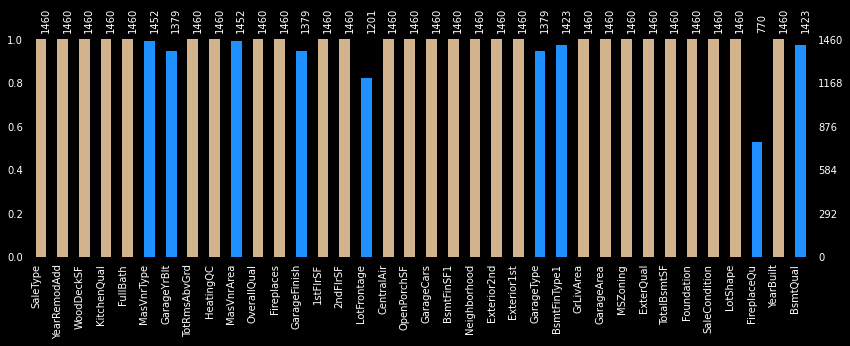

In [367]:
import missingno as msno
import matplotlib.pyplot as plt
plt.style.use('dark_background')

missing_mask = (
    data[selected_feature].isna().sum() != 0
).values

missing_feature = [f for (f, m) in zip(selected_feature, missing_mask) if m == True]

missing_map = {
    True: 'dodgerblue', 
    False: 'tan'
}
missing_mask = [missing_map[m] for m in missing_mask]

msno.bar(
    data[selected_feature],
    figsize=(14, 4), fontsize=10, label_rotation=90,
    color=missing_mask
)
plt.show()

이제 본격적으로 결측치 처리를 할건데요.

결측치 처리에는 크게 세가지가 존재해요.

이 장에서는 결측치 예측을 진행할 것이고

먼저 연속형 피처를 처리하도록 하죠.

In [368]:
nummeric_feature = list()
categoric_feature = list()

for (f, m) in zip(selected_feature, missing_mask):
    if m != 'dodgerblue':
        continue
        
    if f in data.dtypes[data.dtypes != 'object'].index:
        nummeric_feature.append(f)
    else:
        categoric_feature.append(f)

missing_feature = nummeric_feature + categoric_feature

print(f'nummerical feature count = {len(nummeric_feature)}')

nummerical feature count = 3


그나저나 피처가 정말 잘 뽑힌게 맞나요?

상관 관계로 이를 짐작해 볼 수 있지 않을까요?

네. 확인해봅시다.

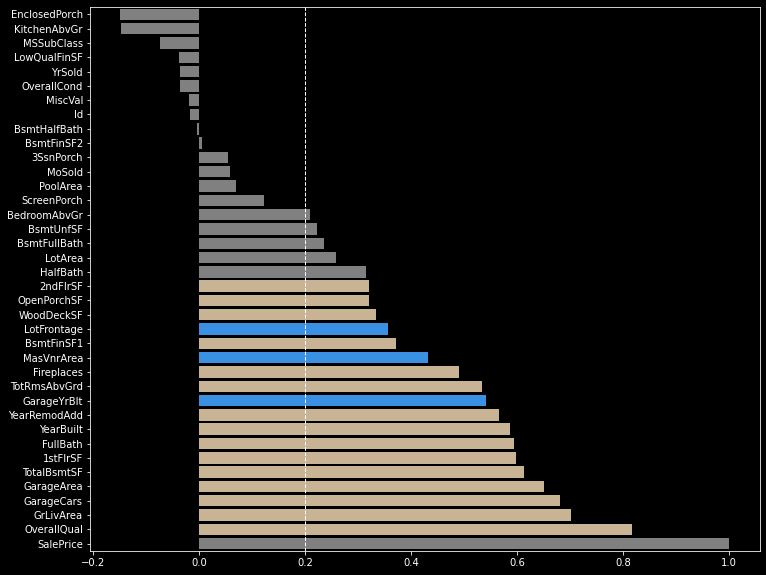

In [369]:
import numpy as np
import seaborn as sns

plt.subplots(figsize=(12, 10))

correlated_feature = data.corr().SalePrice.sort_values()

missing_mask_ = [1 if f in missing_feature else 2 for f in correlated_feature.index]
selected_mask_ = [3 if f in selected_feature else 1 for f in correlated_feature.index]

correlated_mask = np.multiply(
    missing_mask_,
    selected_mask_
)

correlated_map = {
    1: 'gray',
    2: 'gray',
    3: 'dodgerblue',
    6: 'tan'
}
correlated_mask = [correlated_map[f] for f in correlated_mask]

sns.barplot(
    x=correlated_feature.values,
    y=correlated_feature.index,
    orient='h',
    palette=correlated_mask
)
plt.axvline(x=0.2, linewidth=1, linestyle='--')
plt.show()

네. 결과를 보아하니 중요한 피처가 맞습니다.

그럼 세가지 연속형 피처 결측을 예측해야겠죠?

여러가지 방법이 있을텐데요.

오늘은 상관 관계가 높은 피처로 이를 예측합니다.

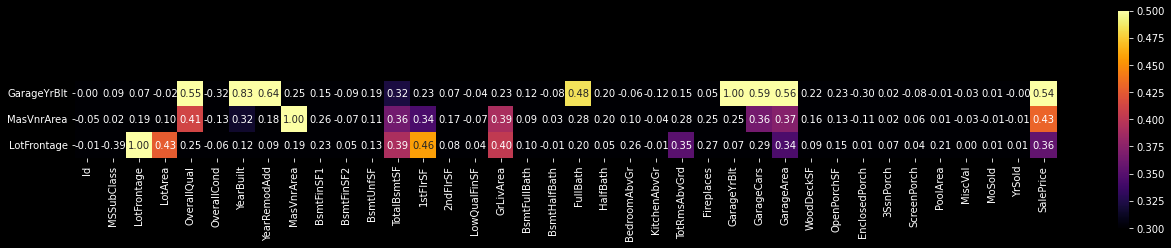

In [370]:
plt.subplots(figsize=(22, 4))

sns.heatmap(
    data.corr().filter(
        nummeric_feature).T,
    cbar=True, annot=True, square=True, fmt='.2f',
    cmap='inferno', vmin=0.3, vmax=0.5
)
plt.show()

자 이제 관계가 높은 데이터를 바탕으로

예측을 진행해주면 될 것 같습니다.

결측치 대체는 하기 라이브러리를 사용합니다.

```
pip install autoimpute
```

In [ ]:
from autoimpute.imputations import SingleImputer

seed = 27

imputer = SingleImputer(
    strategy={
        'LotFrontage': 'pmm',
        'MasVnrArea': 'pmm', 
        'GarageYrBlt': 'pmm'
    },
    predictors={
        'LotFrontage': ['1stFlrSF', 'GrLivArea', 'LotArea'], 
        'MasVnrArea': ['OverallQual', 'GrLivArea', 'GarageArea'],
        'GarageYrBlt': ['YearBuilt', 'YearRemodAdd'],
    },
    seed=seed
)
imputer.fit(data)

%time data = imputer.transform(data)

아래와 같이 세가지 연속형 피처의 빈값이

예측된 것을 확인할 수 있습니다.
- LotFrontage
- MasVnrArea
- GarageYrBlt

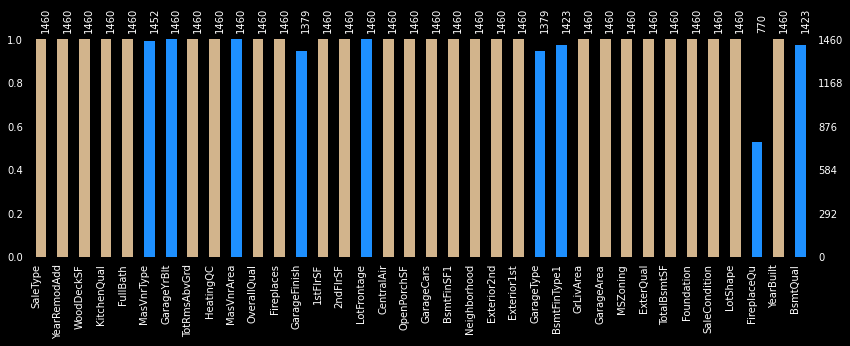

In [372]:
msno.bar(
    data[selected_feature],
    figsize=(14, 4), fontsize=10, label_rotation=90,
    color=missing_mask
)
plt.show()

이제 이산형 변수를 예측할 건데요.

이번에는 모든 변수를 활용해서 예측을 해보겠습니다.

단 결측 개수가 너무 많은 변수는 

추후 모델링 시에 고려 대상임이 분명해 보이네요.
- FireplaceQu 컬럼은 고려 대상

In [373]:
imputed_feature = (
    data[categoric_feature].isna().sum()
).to_frame('Isna')

imputed_feature.T

,MasVnrType,GarageFinish,GarageType,BsmtFinType1,FireplaceQu,BsmtQual
Isna,8,81,81,37,690,37


이제 이산형 변수를 예측할 건데요.

이번에는 모든 변수를 활용해서 예측을 해보겠습니다.

In [374]:
imputer = SingleImputer(
    strategy={f: 'categorical' for f in categoric_feature},
    predictors={f: 'all' for f in categoric_feature},
    seed=seed,
)
imputer.fit(data)
data = imputer.transform(data)

마지막으로 결측 개수를 확인하면

모두 잘 채워진 것을 확인할 수 있습니다.

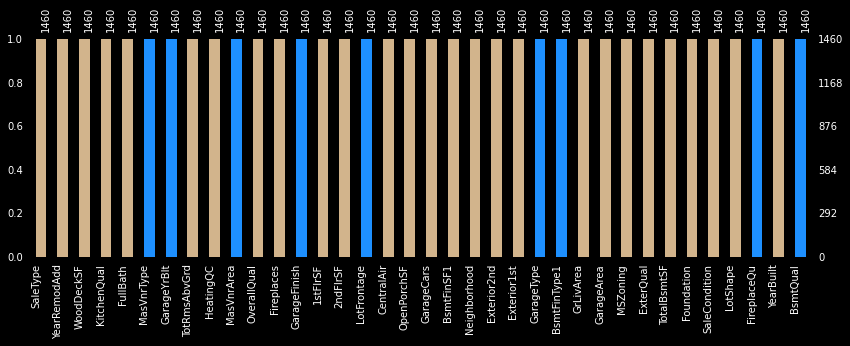

In [375]:
msno.bar(
    data[selected_feature],
    figsize=(14, 4), fontsize=10, label_rotation=90,
    color=missing_mask
)
plt.show()

이제 모델링을 위해 훈련과 테스트셋을 분리합니다.

In [376]:
from sklearn.model_selection import train_test_split

x_data = data[selected_feature]
y_data = data[target_name]

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.3, random_state=seed
)

print(f'train shape = {x_train.shape}, {y_train.shape}')
x_train.head(2)

train shape = (1022, 36), (1022,)


,SaleType,YearRemodAdd,WoodDeckSF,KitchenQual,FullBath,...,SaleCondition,LotShape,FireplaceQu,YearBuilt,BsmtQual
805,New,2008,0,Ex,2,...,Partial,IR1,Gd,2008,Gd
248,WD,2003,144,Gd,2,...,Normal,Reg,TA,2003,Gd


베이스라인 모델링 마지막 부분입니다.

피처 엔지니어링 전에 오토 사이킷런으로 예측 베이스라인을 잡을거에요.

- 10분간 적합한 모델 탐색
- 앙상블 크기는 5

모델링에는 하기 라이브러리를 사용해요.

```
!pip install auto-sklearn
```

In [ ]:
from autosklearn.regression import AutoSklearnRegressor
from autosklearn.metrics import root_mean_squared_error

minute = 10

automl = AutoSklearnRegressor(
    load_models=True,
    time_left_for_this_task=60*minute,
    resampling_strategy='cv',
    metric=root_mean_squared_error,
    ensemble_size=5,
    memory_limit=10**4,
    seed=seed,
)
automl.fit(x_train, y_train)

예측 결과와 앙상블에 활용된 모델을 표시합니다.

베이스라인 결과를 바탕으로 개선을 실시할 수 있습니다.

In [380]:
y_pred = automl.predict(
    x_test[selected_feature]
)
test_score = root_mean_squared_error(
    y_test, y_pred
)

print(f'test score = {-test_score:.5f}')

automl.leaderboard()

test score = 0.14943


,rank,ensemble_weight,type,cost,duration
model_id,,,,,
18,1,0.8,extra_trees,0.142609,18.234271
17,2,0.2,extra_trees,0.146299,15.660621


피처 엔지니어링에 사용할 데이터를 출력합니다.

In [382]:
prep_data = pd.concat(
    [x_data, y_data], 
    axis=1
)
prep_data.to_csv('house_price_prepared.csv', header=True, index=False)

print(f'prepared data shape = {prep_data.shape}')
prep_data.head(2)

prepared data shape = (1460, 37)


,SaleType,YearRemodAdd,WoodDeckSF,KitchenQual,FullBath,...,LotShape,FireplaceQu,YearBuilt,BsmtQual,SalePrice
0,WD,2003,0,Gd,2,...,Reg,Gd,2003,Gd,12.247699
1,WD,1976,298,TA,2,...,Reg,TA,1976,Gd,12.109016
